<a href="https://colab.research.google.com/github/bsureshkrishna/qlsc600_2025/blob/main/sdt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Just defining a whole bunch of convenience functions here in the next cell. Can skip unless one wants to change it later.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, convolve, find_peaks
from scipy.stats import gamma, norm, skewnorm, binom, poisson
from scipy.integrate import quad
import math
import sklearn
from sklearn.metrics import auc
from numpy import real, pi
from scipy.fft import fft, ifft, fftfreq #Documentation: https://docs.scipy.org/doc/scipy/reference/fft.html#module-scipy.fft

def plot_signal_spectrum(signal, fs, plotornot = 1):
    # Compute the FFT
    fft_result = np.fft.fft(signal)

    # Compute the frequency bins
    freqs = np.fft.fftfreq(len(signal), d=1/fs)

    # Compute the magnitude (absolute value of the FFT)
    magnitude = np.abs(fft_result)

    if(plotornot==1):
        # Plotting
        sorted_indices = np.argsort(freqs)
        magnitude=magnitude[sorted_indices]
        freqs=freqs[sorted_indices]
        plt.plot(freqs, magnitude)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.title('Spectrum')

    return freqs, magnitude

def amplitude_from_spl(spl):
    amplitude = np.power(10,(spl/20))*20*1e-6 #amplitude in pascals, since reference of 0dB = 20 micropascals
    return amplitude

def generate_tone(t,spl,frequency, phasevalue=0):
    #supply amplitdue in sound pressure level (decibels), frequency in hz
    amplitude = amplitude_from_spl(spl) #amplitude in micropascals, since reference of 0dB = 20 micropascals
    signal = amplitude*np.sin(2.0*np.pi*frequency*t+phasevalue) #a simple sine-wave to use as signal
    return signal

def nonlinearity(amplitudes, x0=10, Rmax=100, sigma=40):
    x0=-1.0*amplitude_from_spl(x0)
    if sigma<=0:
      sigma=sigma+0.1
    if Rmax<sigma:
      Rmax=sigma+10
    km=x0**2*((Rmax/sigma)-1) #km is defined in terms of sr.
    x = np.array(amplitudes)  # Ensure x is a NumPy array
    return np.where(x < x0, 0, Rmax * (x - x0)**2 / ((x - x0)**2 + km))

def timeplot(signal,fs,colorvar='blue'):
    plt.plot((1/fs)*np.arange(0,len(signal)),signal,color=colorvar)

def generate_gammatone(timeax,f=440,b=50,n=4,a=1,phi=0):
    gammapart=a*timeax**(n-1)*np.exp(-2.0*np.pi*b*timeax)
    gammapart=2*gammapart/np.trapz(gammapart)
    cospart=np.cos(2.0*np.pi*f*timeax) # a hack normalization to make convolution output "preserve" amplitude
    gammatone_impresp=cospart*gammapart #impulse response of gammatone filter
    return gammatone_impresp

def generate_samtone(t,spl,frequency, phasevalue=0, amfrequency=10):
    #supply amplitdue in sound pressure level (decibels), frequency in hz
    amplitude = amplitude_from_spl(spl) #amplitude in micropascals, since reference of 0dB = 20 micropascals
    signal = amplitude*(1+np.sin(2*np.pi*amfrequency*t-(np.pi)/2))*np.sin(2.0*np.pi*frequency*t+phasevalue) #a simple sine-wave to use as signal
    return signal

def print_vars(**kwargs):
    output = "; ".join([f"{name} = {value}" for name, value in kwargs.items()])
    print(output)

def myfft(signal, timeaxis, fs):
    #function calculates fft and ifft given signal
  signal_fft = (fft(signal, norm="forward")) #calculate forward (normalized) fft. in general, will be complex
  signal_ifft = real(ifft(signal_fft, norm="forward")) #invert the fft to hopefully recreate original signal. note that you cannot ignore phase !
  freqaxis = fftfreq(len(signal),d=1/fs) #frequency x-axis for fft
  return signal_fft, signal_ifft, freqaxis

def plotmyfft(signal, timeaxis, signal_fft, signal_ifft, freqaxis, fs):
    #function plots signal, fft and ifft
  fig,axs = plt.subplots(nrows = 3,
                         ncols = 1,
                         constrained_layout="true")

  ax=axs[0]
  ax.plot(timeaxis,signal) #plot signal
  ax.set_xlabel("Time (s)")
  ax.set_ylabel("Signal")
  ax.set_title("Signal")

  ax=axs[1]
  fft_abs=abs(signal_fft) #take the absolute value (aka magnitude) of the fft
  ax.plot(freqaxis,fft_abs) #plot fft magnitude. ignoring phase here
  peaks, _ = find_peaks(fft_abs, height=0.4) # You might need to adjust the height parameter based on your data
  ax.scatter(freqaxis[peaks], fft_abs[peaks], color='red') # mark peak points
  # Print peaks
  for peak in peaks:
    print_vars(peak=freqaxis[peak],magnitude=fft_abs[peak])
  ax.set_xlabel("Frequency (Hz)")
  #ax.set_xlim([-100, 100])
  ax.set_ylabel("Magnitude")
  ax.set_title("FFT of Signal")

  ax=axs[2]
  ax.plot(timeaxis,signal_ifft) #plot recovered time signal
  ax.set_xlabel("Time (s)")
  ax.set_ylabel("Recovered Signal")
  ax.set_title("Inverse FFT of Signal (Recovered signal)")

  return

def plotmyfft2(signal, timeaxis, signal_fft, freqaxis, fs):
    #function plots signal and fft.
  fig,axs = plt.subplots(nrows = 2,
                         ncols = 1,
                         constrained_layout="true")

  ax=axs[0]
  ax.plot(timeaxis,signal) #make plots
  ax.set_xlabel("Time (s)")
  ax.set_ylabel("Signal")
  ax.set_title("Signal")

  ax=axs[1]
  fft_abs=abs(signal_fft) #take the absolute value (aka magnitude) of the fft
  ax.plot(freqaxis,fft_abs) #plot fft magnitude. ignoring phase here
  peaks, _ = find_peaks(fft_abs, height=0.05) # You might need to adjust the height parameter based on your data
  ax.scatter(freqaxis[peaks], fft_abs[peaks], color='red') # mark peak points

  # Print peaks
  for peak in peaks:
    print_vars(peak=freqaxis[peak],magnitude=fft_abs[peak])

  ax.set_xlabel("Frequency (Hz)")
  # ax.set_xlim([-100, 100])
  ax.set_ylabel("Magnitude")
  ax.set_title("FFT of Signal")

PART 1a: Basic intro to linear systems

First we generate two sine-waves and look at their Fourier magnitude spectra.

peak = 30.0; magnitude = 0.5000000000000001
peak = -30.0; magnitude = 0.5000000000000001
--------------------------------------------------


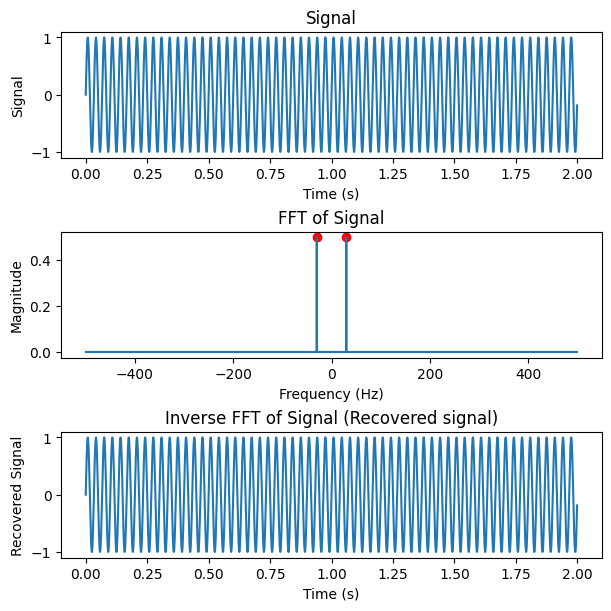

In [ ]:
plt.rcParams['figure.figsize'] = [6, 6] #set figure dimensions

fs = 1000.0 #sampling frequency
timeaxis = np.arange(0,2.0,step=1/fs)

freq = 30 #sine-wave frequency
amp = 1 #amplitude
signal1 = amp * np.sin(2.0*pi*freq*timeaxis) #create sine wave

signal1_fft, signal1_ifft, freqaxis =  myfft(signal1, timeaxis, fs)
plotmyfft(signal1, timeaxis, signal1_fft, signal1_ifft, freqaxis, fs)
vals1 = find_peaks(abs(signal1_fft),0.04)
print('--------------------------------------------------')

peak = 10.0; magnitude = 5.0
peak = -10.0; magnitude = 5.0
--------------------------------------------------


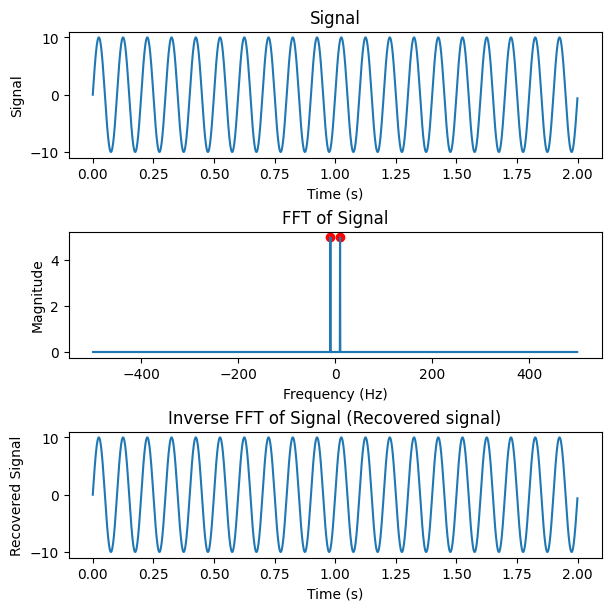

In [ ]:
#change sine-wave frequency and amplitude. identify and interpret effects on plot


freq=10 #sine-wave frequency
amp=10 #amplitude
signal2 = amp * np.sin(2.0*pi*freq*timeaxis) #create sine wave

signal2_fft, signal2_ifft, freqaxis =  myfft(signal2, timeaxis, fs)
plotmyfft(signal2, timeaxis, signal2_fft, signal2_ifft, freqaxis, fs)
vals2 = find_peaks(abs(signal2_fft),0.04)
print('--------------------------------------------------')

Now using the code above as a template - experiment with the frequency content of signals. For example:

1. What happened to the Fourier transform (FT) when the amplitude and frequency of the sine-wave were changed ? Why ?
2. Try other values for frequency and amplitude and confirm.
3. Try adding a phase to the sine-wave. What happens to the plotted FT ?
4. Add two sine-waves - what happens to the frequency spectrum ? Change the amplitude of each sine-wave and comment on what happens
5. Go back to a single sine-wave. Rectify it - this is a non-linear operation (why ?). What happens to the frequency spectrum ?

Now take a look at a couple of new signals and their Fourier transforms.

Signal 1 - acts as a low-pass filter. What does this mean ? And why ? Explain in the time and frequency domains.

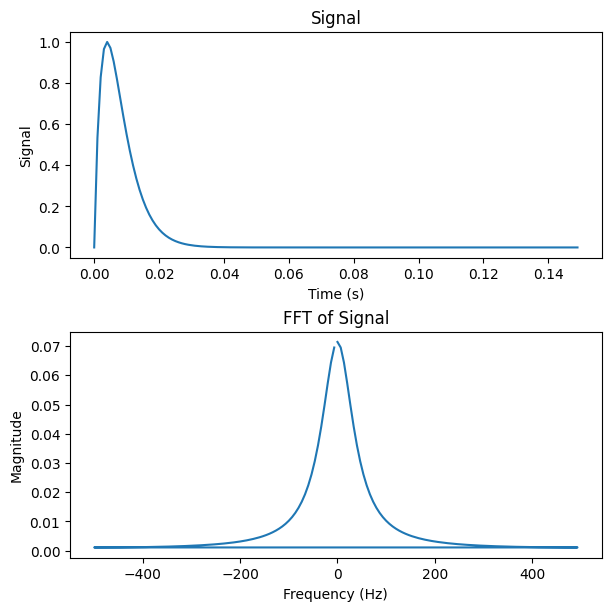

In [ ]:
timeaxis2=np.arange(0,0.15,step=1/fs)# Time values from 0 to 500 milliseconds
alpha = 5
beta = 250
y = (1 - np.exp(-alpha * timeaxis2)) * np.exp(-beta * (timeaxis2 - 0.1))
y=y/max(y)

y_fft, y_ifft, y_freqaxis =  myfft(y, timeaxis2, fs)
plotmyfft2(y, timeaxis2, y_fft, y_freqaxis, fs)


Let us generate a sine-wave. Filter it by y, either by convolution in the time-domain or multiplication in the frequency domain (followed by an ifft). Do they give the same response ? Look carefully at the end of the output.. why does the output extend beyond 2 s ?

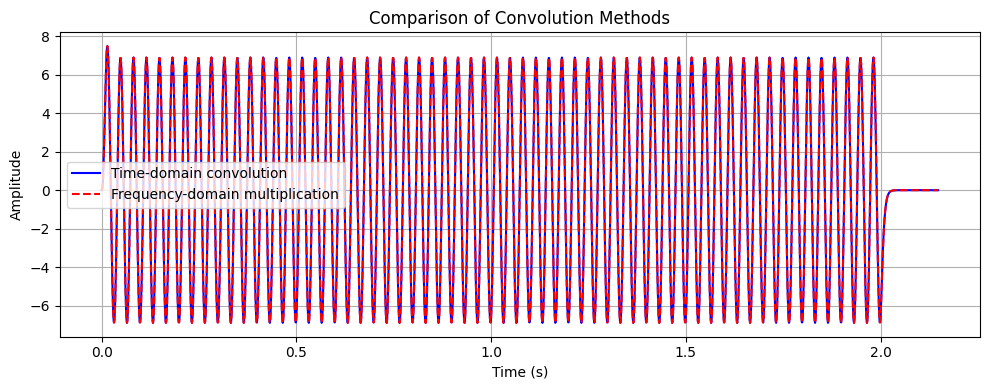

In [ ]:

freq1=30 #sine-wave frequency
amp1=1 #amplitude
signal1=amp1*np.sin(2.0*pi*freq1*timeaxis) #create sine wave
signal1_fft, signal1_ifft, freqaxis =  myfft(signal1, timeaxis, fs)

# Time-domain convolution
result_time_domain = convolve(signal1, y, mode='full',method="direct") #this is scipy.signal.convolve, method = direct forces time-domain convolution

# Frequency-domain multiplication
N = len(signal1) + len(y) - 1  # this is the size after convolution
X = fft(signal1, n=N)
Y = fft(y, n=N)
result_frequency_domain = real(ifft(X * Y)) #you could check that the imaginary parts are just very small numerical errors

# Plotting the results
plt.figure(figsize=(10, 4))
plt.plot((1/fs)*np.arange(0,len(result_time_domain)),
         result_time_domain,
         label='Time-domain convolution',
         color='blue')
plt.plot((1/fs)*np.arange(0,len(result_frequency_domain)),
         result_frequency_domain,
         label='Frequency-domain multiplication',
         color='red',
         linestyle='--')
plt.title("Comparison of Convolution Methods")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# To ensure that both methods produce nearly the same result
# (There can be very tiny differences due to numerical precision)
assert np.allclose(result_time_domain, result_frequency_domain, atol=1e-5), "The results are not the same!"


For longer signals, and with naive implementations, a method based on fft will be much faster. One can probably also just use convolve and leave it to numpy/scipy to figure it out (NAPE - not a python expert).

Now let us test that low-pass filter claim a bit. First generate a sine-wave with different frequencies: 30 Hz and 200 Hz. Filter it by y. Before running the code, what do you expect ? Is the prediction easier from the time-domain or from the frequency domain ?

Try some other sine-wave frequencies. Stay well below 500 Hz, to avoid aliasing. If you want to use higher frequencies, what needs to change ?

Try a sum of two sinusoids, like 30 Hz and 200 Hz. What does the output look like ? Why ? Plot both the output signal and its Fourier transform. Interpret it.

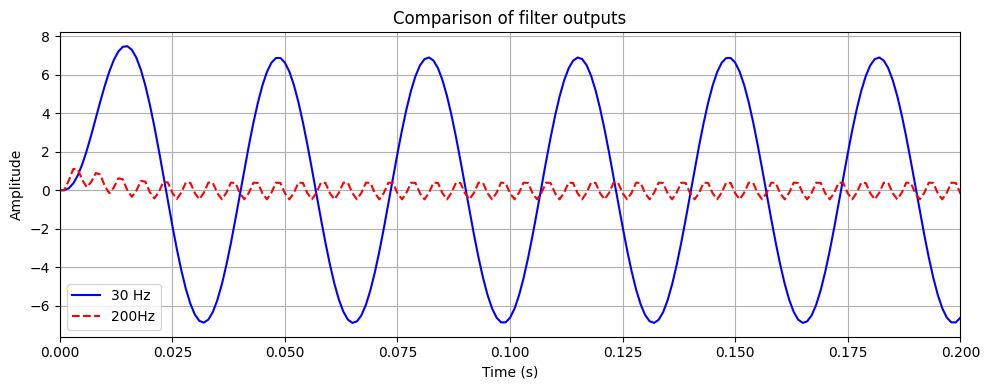

In [ ]:
freq1=30 #sine-wave frequency
amp1=1 #amplitude
signal1=amp1*np.sin(2.0*pi*freq1*timeaxis) #create sine wave
output1 = np.convolve(signal1, y, mode='full')

freq2=200#sine-wave frequency
amp2=1 #amplitude
signal2=amp2*np.sin(2.0*pi*freq2*timeaxis)  #create sine wave
output2 = np.convolve(signal2, y, mode='full')

plt.figure(figsize=(10, 4))
plt.plot((1/fs)*np.arange(0,len(output1)),
         output1,
         label=str(freq1)+" Hz",
         color='blue')
plt.plot((1/fs)*np.arange(0,len(output2)),
         output2,
         label=str(freq2) + "Hz",
         color='red',
         linestyle='--')
plt.title("Comparison of filter outputs")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.xlim([0,0.2])
plt.tight_layout()
plt.show()

Finally, let us try a different filter. Try to predict its effect on the same sinusoids at 30 Hz and 200 Hz, and the sum of the two.

Why does this filter, from its time-domain properties (and definition in code) have a spectrum that looks as it does ? Can you intuitively understand this ?

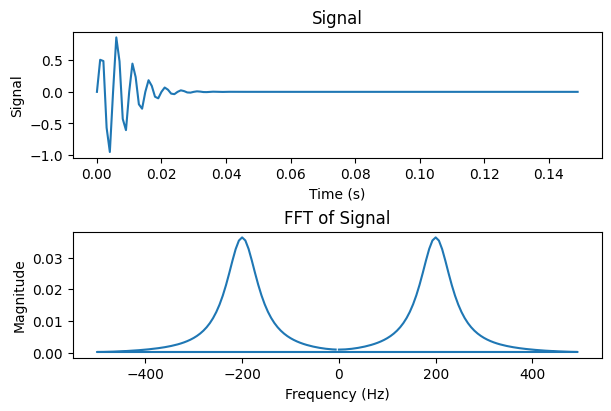

In [ ]:
plt.rcParams['figure.figsize'] = [6, 4]

center_freq=200
y2=y*np.sin(2.0*pi*center_freq*timeaxis2) #create sine wave, multiplied by the previous filter y

y2_fft, y2_ifft, y2_freqaxis =  myfft(y2, timeaxis2, fs)
plotmyfft2(y2, timeaxis2, y2_fft, y2_freqaxis, fs)

Part 1b: Intro to signal-detection theory

This part will come in very useful in next week's lecture by Erik Cook. Today, it is optional in case you dont have time.

Let us consider an experiment where one half of trials contains the signal and the other half contains the noise, and what we get is a noisy measurement from the trial, that has some information about whether it was a signal trial or a noise trial. This situation is very general. For example (without paying attention to the relative proportions of signal and noise in these examples):

1.   An airport security operator sees a bag under the X-ray scanner and tries to determine if it contains a forbidden item or not.
2.   A radiologist sees an X-ray and tries to determine if there is a lesion in it or not.
3.   You hear a sound and try to determine if your name was called or not.
4.   You run a new test on a blood sample and try to determine if a certain condition is present or not.
5.   Come up with a few more.

We can, with many assumptions, model these situations in the simplest case in the following way. For now, let us assume that when the thing we are looking for is present, the response variable can take on a range of values, and when it is not, the response variable takes on another range.

What does it mean to say that the response variable contains information about the presence of the signal ?

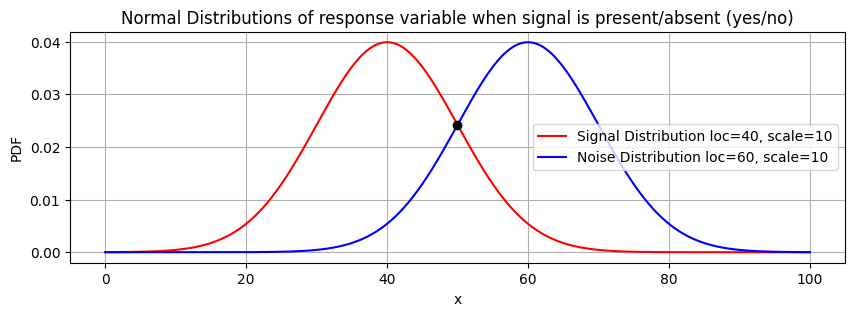

In [ ]:
# Generate x values - the response variable takes values from 0 to 100 (arbitrary)
x = np.linspace(0, 100, 1000)
diff_x=np.linspace(-100,100,1000)

# Parameters for the normal distribution
loc1 = 40  # location parameter (mean)
scale1 = 10  # scale parameter (sd)
loc2 = 60  # location parameter (mean)
scale2 = 10  # scale parameter (sd)

# Compute the PDF values
pdf1 = norm.pdf(x, loc1, scale1)
pdf2 = norm.pdf(x, loc2, scale2)

# Plot the distributions
plt.figure(figsize=(10,3))
plt.plot(x, pdf1, label=f'Signal Distribution loc={loc1}, scale={scale1}',color='red')
plt.plot(x, pdf2, label=f'Noise Distribution loc={loc2}, scale={scale2}',color='blue')

idx = np.argwhere(np.diff(np.sign(pdf2 - pdf1))).flatten()
plt.plot(x[idx], pdf2[idx], 'ko')
intersect_point=x[idx]

plt.title("Normal Distributions of response variable when signal is present/absent (yes/no)")
plt.xlabel("x")
plt.ylabel("PDF")
plt.legend()
plt.grid(True)

plt.show()

One way to do this task is to set a value of a threshold. If the response variable is greater than this value, we say the signal is present, and if not, we say it is absent.

More generally, response variables can be multidimensional (in which case the acceptance region may also be multidimensional). The acceptance region can also be much more complex, even in 1 dimension, if the underlying response variable distributions are. Think about these..

But for now, let us consider the response variable distributions above, and then see what happens as the threshold is varied. Try to predict what happens when you use a very low threshold, a threshold at the intersection point, and a very high threshold..

Area Under the Curve (AUC): 0.9213


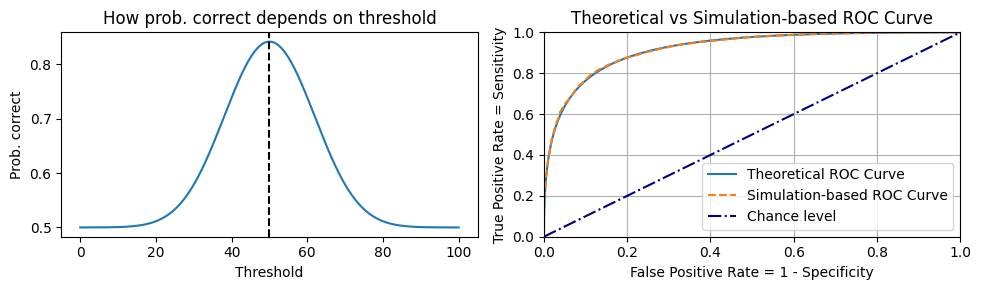

In [ ]:
# Calculate theoretical ROC
fpr_theoretical = []
tpr_theoretical = []

thresholds = np.linspace(min(x), max(x), 1000)

for threshold in thresholds:
    tpr_theoretical.append(1 - norm.cdf(threshold, loc2, scale2))
    fpr_theoretical.append(1 - norm.cdf(threshold, loc1, scale1))

#calculating percentage correct, assuming 50 % of trials are signal (yes/no experiment)
percor_theoretical = 0.5*(np.array(tpr_theoretical) + (1 - np.array(fpr_theoretical)))

# Compute the AUC
roc_auc = auc(fpr_theoretical, tpr_theoretical)
print(f"Area Under the Curve (AUC): {roc_auc:.4f}")

# Simulate samples - for simulation-based roc
n_trials = 10000
n_half = n_trials // 2 #50 % of trials are signal and 50 % are noise

samples_noise = norm.rvs(loc1, scale1, size=n_half)
samples_signal = norm.rvs(loc2, scale2, size=n_half)

labels_noise = np.zeros(n_half)
labels_signal = np.ones(n_half)

samples = np.concatenate([samples_noise, samples_signal])
labels = np.concatenate([labels_noise, labels_signal])

# Calculate simulation-based ROC
fpr_simulation = [] #false-positive rate
tpr_simulation = [] #true-positive rate

for threshold in thresholds:
    predictions = samples > threshold
    tp = np.sum((predictions == 1)&(labels==1))
    fp = np.sum((predictions == 1)&(labels==0))
    tn = np.sum((predictions == 0)&(labels==0))
    fn = np.sum((predictions == 0)&(labels==1))

    tpr_simulation.append(tp / (tp + fn))
    fpr_simulation.append(fp / (fp + tn))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(thresholds, percor_theoretical)
plt.axvline(intersect_point,color='black',linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Prob. correct')
plt.title("How prob. correct depends on threshold")

# Second Column (for the ROC curves)
plt.subplot(1, 2, 2)
plt.plot(fpr_theoretical, tpr_theoretical, label='Theoretical ROC Curve')
plt.plot(fpr_simulation, tpr_simulation, label='Simulation-based ROC Curve', linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', linestyle='-.', label='Chance level')
plt.xlabel('False Positive Rate = 1 - Specificity')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('Theoretical vs Simulation-based ROC Curve')
plt.legend()
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])

# Adjust the layout so plots don't overlap
plt.tight_layout()
plt.show()

The vertical line above in the left column is drawn at the intersection point of the two distributions from above.

Next, let us consider a different task, where on each trial, one gets two-samples,  one from the signal and one from the noise, and one has to determine which one is the one from the signal. An example would be a police line-up with only 1 "foil". Or searching for your friend in a crowd. Etc. Any situation where you know the signal is present, but do not know which of the samples has the signal. (Aside: The relationship of this situation to the one above is like the relationship of a two-sample t-test to a single sample t-test).

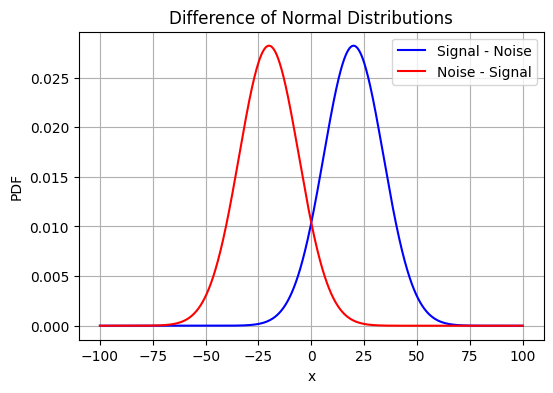

Prob. of being correct in 2-I, 2-AFC task: 0.9214


In [ ]:
#Now consider a two-interval two-alternative forced choice task
#Each trial gives two samples,  and one has to decide which is signal and which is noise
#Let us look at the distribtion of the difference for (signal-noise) and for (noise-signal);
#the latter is just the distribution of -1 multiplied by the former

pdf_diff1=norm.pdf(diff_x,loc2-loc1,math.sqrt(scale1**2+scale2**2)) #variance of difference is sum of individual variances
pdf_diff2=norm.pdf(diff_x,loc1-loc2,math.sqrt(scale1**2+scale2**2))

plt.plot(diff_x, pdf_diff1,color='blue',label='Signal - Noise')
plt.plot(diff_x, pdf_diff2,color='red',label='Noise - Signal')

plt.title("Difference of Normal Distributions")
plt.xlabel("x")
plt.ylabel("PDF")
plt.legend()
plt.grid(True)
plt.show()

percentage_correct = 1 - norm.cdf(0, loc2-loc1,math.sqrt(scale1**2+scale2**2))
print(f"Prob. of being correct in 2-I, 2-AFC task: {percentage_correct:.4f}")

See how there is no threshold setting here, or rather the threshold is set at 0, and no role of response caution. However, there are other confounds and biases, like order effects, tendency to prefer one or other sample etc.

That aside, the probability of being correct in a 2I, 2-AFC task in ideal scenarios is exactly equal to the area under the ROC curve drawn from the yes/no experiment. Compare the value printed below the graph above to the area under the ROC curve mentioned above. Vary the location and scale parameters of the distributions at the top and see how the plots and numbers change.

Next, let us consider a situation where the signal and noise samples do not have an equal chance of appearing on a given trial. For example, many more trials contain the noise sample than the signal sample. Outside of laboratory experiments, unequal proportions is likely much more common. Think of some examples.

For the well-behaved probability distributions, we are considering, the intersection point still locates the optimal threshold criterion. It is also where the sample value becomes more likely under the signal distribution than the noise distribution. However, this intersection is no longer at the midpoint between the two means.

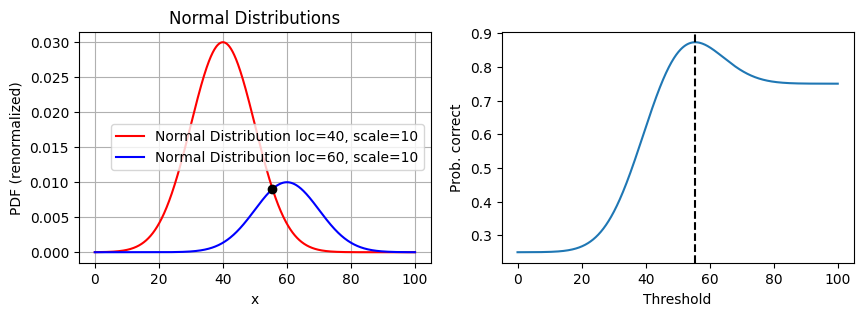

In [ ]:
# Plot the distributions
plt.figure(figsize=(10,3))
pdf11=3*pdf1/4;
pdf22=1*pdf2/4;

#calculating percentage correct, assuming 50 % of trials are signal (yes/no experiment)
percor_theoretical = (np.array(tpr_theoretical) + 3*(1 - np.array(fpr_theoretical)))/4

plt.subplot(1, 2, 1)
plt.plot(x, pdf11, label=f'Normal Distribution loc={loc1}, scale={scale1}',color='red')
plt.plot(x, pdf22, label=f'Normal Distribution loc={loc2}, scale={scale2}',color='blue')

idx = np.argwhere(np.diff(np.sign(pdf22 - pdf11))).flatten()
plt.plot(x[idx], pdf22[idx], 'ko')
intersect_point=x[idx]

plt.title("Normal Distributions")
plt.xlabel("x")
plt.ylabel("PDF (renormalized)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds,percor_theoretical)
plt.axvline(intersect_point,color='black',linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Prob. correct")
plt.show()

Try to understand the plot on the right, and explain why the left and right end of this plot does not lie at 0.5 unlike the situation where the two trial types occurred equally often.

Part 1c: Revision of Poisson processes

We now simulate an inhomogeneous Poisson process using the time-rescaling method. There are other methods as well.. e.g. thinning, that we will not cover here. For homogeneous processes, just simulating an exponential distribution for the inter-event times is perhaps the easiest.

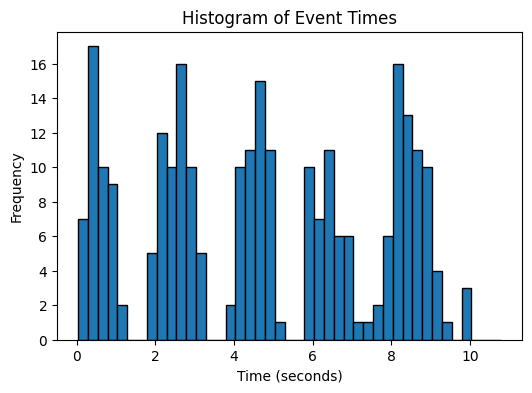

In [ ]:
def simulate_inhomogeneous_poisson(times, rate_function):
    # Integrate the rate function to get the compensator (cumulative rate function)
    compensator = np.cumsum(rate_function) * (times[1] - times[0])
    # Generate a standard Poisson process with rate 1
    n_events = np.random.poisson(compensator[-1])
    standard_poisson_events = np.sort(np.random.uniform(0, compensator[-1], n_events))

    # Apply the inverse of the cumulative rate function to the event times
    # We find where each standard Poisson event would fall in the compensator
    inhomogeneous_poisson_events = np.searchsorted(compensator, standard_poisson_events, side='left')
    inhomogeneous_poisson_events_times = times[inhomogeneous_poisson_events]

    return inhomogeneous_poisson_events_times

# Example usage:
times = np.linspace(0, 10, 10000)  # Define the time points
rate_function = np.sin(2.0*np.pi*0.5*times) * 25 + 25  # Define the rate function, ensuring it is non-negative
events = simulate_inhomogeneous_poisson(times, rate_function)
# Now 'events' contains the event times of the inhomogeneous Poisson process'

# Create a histogram
plt.hist(events, bins=np.arange(min(events), max(events)+1,0.25), edgecolor='black')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Event Times')
plt.show()

Now play with  this code. Generate a homogeneous poisson process instead (how) ? Plot the inter-event interval times - how ? this is just the histogram of times between events. What does it look like for the homogeneous process ? Why ? What about for the inhomogeneous process we started with ?